# Postprocessing for the eigenvalue solutions

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, h5py
from pg_utils.processing import postproc as pproc
from sympy import srepr, parse_expr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Eigenvalue comparison

Read in eigenvalue solutions

In [82]:
solution_file_list = [
    
    # # Different recipes for Malkus bg field
    # "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    # "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5", 
    # "./out/cases/Malkus/MM_recipe/Eigen.h5",
    # "./out/cases/Malkus/MM_quad_Malkus/Eigen.h5",
    
    # # Final three approaches for Malkus bg field
    # "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5",
    # "./out/cases/Malkus/Conjugate_recipe/Eigen.h5", 
    # "./out/eigen/Malkus/Transformed/eigen_m3_N5.h5",
    # "./out/cases/Malkus/Reduced_sys/Eigen.h5",
    # "./out/eigen/Malkus/Reduced/eigen_m3_N5.h5"
    
    # Malkus bg field
    "./out/eigen/Malkus/Original/eigen_m3_N50.h5",
    "./out/eigen/Malkus/Transformed/eigen_m3_N50.h5",
    "./out/archived/Malkus/Conjugate_recipe/Eigen_N100.h5",
    "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5",
    
    # Hydrodynamic modes
    # "./out/eigen/Hydrodynamic/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50.h5",
    
    # Toroidal quadrupolar modes
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_N50.h5",
    
    # Poloidal dipolar modes
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Poloidal_Dipole/Reduced/eigen_m3_N50.h5"
]
src_names = [
    
    # # Different recipes for Malkus bg field
    # "Code Daria Mathematica", 
    # "PlesioGeostroPy-mp32", 
    # "PlesioGeostroPy-scipy", 
    # "PlesioGeostroPy-PG-Daria",
    # "PlesioGeostroPy: Recipe Daria quad_Malkus",
    
    # # Final three approaches for Malkus bg field
    "Recipe Holdenried-Chernoff (2021)",
    "Conjugate variables", 
    "Conjugate variables (Unitary)", 
    "Reduced system",
    # "Reduced system (v2)",
    
    # Hydrodynamic modes
    # "Conjugate variables",
    # "Reduced system",
    
    # Toroidal quadrupolar modes
    # "Transformed variables",
    # "Reduced system",
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    with h5py.File(fname, 'r') as f:
        solution_list.append(f["eigval"][()])
        if "azm" in fread.attrs.keys():
            azm_val = fread.attrs["azm"]
            Le_val = fread.attrs["Le"]
        else:
            azm_val = fread.attrs[srepr(xpd.m)]
            Le_val = fread.attrs[srepr(params.Le)]

if "Mathematica" in src_names[0].split():
    solution_list[0] = 1j*solution_list[0]

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [83]:
func_collections = [
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag)
]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [75]:
func_colletions = [
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
]

Collect the results according to the classification criterion

In [97]:
df_colletions = [pd.DataFrame() for func in func_collections]
uniform_trunc = [20 for func in func_collections]
for i_src, srcname in enumerate(src_names):
    eig_vals_classes = pproc.classify_eigens_criteria(solution_list[i_src], func_collections)
    eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]
    for i_df, dftmp in enumerate(df_colletions):
        dftmp[srcname] = eig_vals_classes[i_df][:uniform_trunc[i_df]]

### Add reference solution

If exists, the analytic solutions can be added.

In [98]:
from pg_utils.numerics import utils as nutils

n_eigs = np.arange(1, 21)

# Malkus modes

omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, mode="all", timescale="alfven")
df_colletions[0]["Analytic PG"] = omega_fast*1j
df_colletions[1]["Analytic PG"] = omega_slow*1j

omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, mode="all", timescale="alfven")
df_colletions[0]["Analytic 3D"] = omega_fast*1j
df_colletions[1]["Analytic 3D"] = omega_slow*1j

# Inertial modes

# omega_inertial = nutils.eigenfreq_psi_op(3, n_eigs)
# df_colletions[0]["Analytic PG"] = omega_inertial*1j

# omega_inertial_3d = nutils.eigenfreq_inertial3d(3, n_eigs)
# df_colletions[0]["Analytic 3D"] = omega_inertial_3d*1j

In [99]:
df_colletions[1].style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,Recipe Holdenried-Chernoff (2021),Conjugate variables,Conjugate variables (Unitary),Reduced system,Analytic PG,Analytic 3D
0,"-3.22e-16,4.1249928e-03j","-9.66e-16,4.1249928e-03j","-1.57e-15,4.1249928e-03j","7.27e-17,4.1249928e-03j","0.00e+00,4.1249928e-03j","0.00e+00,3.8545349e-03j"
1,"1.86e-15,8.0249447e-03j","-4.02e-16,8.0249447e-03j","-1.04e-15,8.0249447e-03j","1.18e-15,8.0249447e-03j","0.00e+00,8.0249447e-03j","0.00e+00,7.8795505e-03j"
2,"-1.55e-15,1.3124755e-02j","3.62e-15,1.3124755e-02j","-1.67e-14,1.3124755e-02j","-1.70e-15,1.3124755e-02j","0.00e+00,1.3124755e-02j","0.00e+00,1.3033436e-02j"
3,"2.64e-15,1.9424198e-02j","-8.29e-16,1.9424198e-02j","-5.22e-15,1.9424198e-02j","1.64e-15,1.9424198e-02j","0.00e+00,1.9424198e-02j","0.00e+00,1.9361512e-02j"
4,"-3.29e-15,2.6922856e-02j","-9.60e-15,2.6922856e-02j","3.05e-15,2.6922856e-02j","-3.95e-16,2.6922856e-02j","0.00e+00,2.6922856e-02j","0.00e+00,2.6877183e-02j"
5,"3.00e-15,3.5620020e-02j","-4.58e-15,3.5620020e-02j","6.20e-15,3.5620020e-02j","1.66e-15,3.5620020e-02j","0.00e+00,3.5620020e-02j","0.00e+00,3.5585279e-02j"
6,"-6.52e-16,4.5514590e-02j","-3.55e-15,4.5514590e-02j","1.59e-14,4.5514590e-02j","2.47e-15,4.5514590e-02j","0.00e+00,4.5514590e-02j","0.00e+00,4.5487287e-02j"
7,"-1.28e-15,5.6604948e-02j","1.37e-15,5.6604948e-02j","-4.68e-15,5.6604948e-02j","-3.37e-15,5.6604948e-02j","0.00e+00,5.6604948e-02j","0.00e+00,5.6582933e-02j"
8,"-8.47e-16,6.8888814e-02j","5.40e-15,6.8888814e-02j","-3.59e-15,6.8888814e-02j","1.47e-15,6.8888814e-02j","0.00e+00,6.8888814e-02j","0.00e+00,6.8870693e-02j"
9,"-4.25e-16,8.2363099e-02j","-3.78e-15,8.2363099e-02j","-5.98e-15,8.2363099e-02j","1.85e-15,8.2363099e-02j","0.00e+00,8.2363099e-02j","0.00e+00,8.2347928e-02j"


Additionally, compute the difference from reference

In [123]:
df_compare = df_colletions[0]
ref_name = "Analytic PG"

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[ref_name] - df_compare[srcname])/np.abs(df_compare[ref_name])

df_compare_err.style.format(formatter=lambda x: "{:.7e}".format(x))

,Recipe Holdenried-Chernoff (2021),Conjugate variables,Conjugate variables (Unitary),Reduced system
0,9.6633643e-16,3.8810051e-25,1.9326729e-15,0.0000000e+00
1,1.5612885e-15,2.1467717e-15,5.4645097e-15,9.7585783e-16
2,2.3435766e-31,2.4300107e-15,4.8600214e-16,4.8600214e-16
3,7.2472368e-16,3.0196820e-15,6.0393640e-16,7.3472034e-16
4,3.5312557e-15,7.7348259e-15,2.6903742e-15,3.7599123e-16
5,3.2640299e-15,2.0077131e-15,5.5769808e-15,3.2423321e-15
6,5.0207156e-15,7.1393217e-15,3.1413015e-15,3.0019128e-15
7,6.0533164e-15,7.9748984e-27,8.0014294e-15,1.6393230e-15
8,1.1265461e-14,5.6316457e-15,5.8482475e-15,1.0830088e-15
9,6.8812622e-15,1.3605550e-14,1.7752003e-14,2.8974292e-16


### Eigenvalue plot

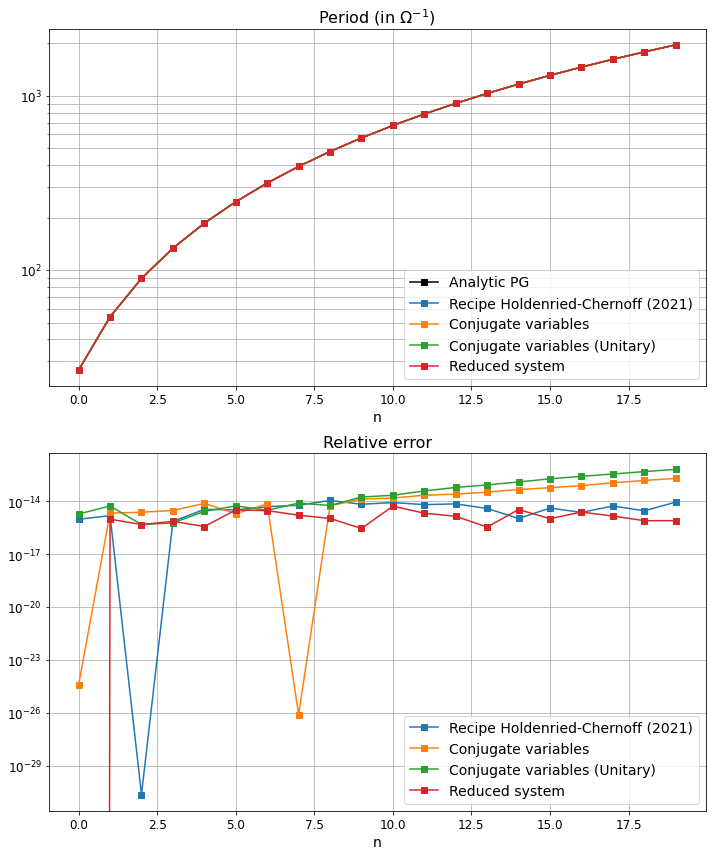

In [128]:
df_view = df_colletions[0]
ref_name = "Analytic PG"
df_err_view = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_err_view[srcname] = np.abs(df_view[ref_name] - df_view[srcname])/np.abs(df_view[ref_name])
n_view = 20

# save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/Analytical_error"
save_name = None
override = False

if df_err_view is None:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    ax = axes
else:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
    ax = axes[0]

ax.semilogy(np.arange(n_view), 2*np.pi*1e+4/np.abs(np.imag(df_view[ref_name].iloc[:n_view])), 'ks-', label=ref_name)
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(n_view), 2*np.pi*1e+4/np.abs(np.imag(df_view[srcname][:n_view])), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=14)
ax.set_xlabel("n", fontsize=14)
ax.set_title("Period (in $\Omega^{-1}$)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

if df_err_view is not None:
    ax = axes[1]
    for idx, srcname in enumerate(src_names):
        ax.semilogy(np.arange(n_view), df_err_view[srcname][:n_view], 's-', label=srcname)
    ax.grid(which="both")
    ax.legend(fontsize=14)
    ax.set_xlabel("n", fontsize=14)
    ax.set_title("Relative error", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_ylim([1e-17, 1e-12])

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", bbox_inches="tight")
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")
plt.show()

---
## Eigenmode visualization

Reading data

In [31]:
from scipy import special as specfun
from pg_utils.pg_model import core, base, params
from pg_utils.pg_model import expansion as xpd
from pg_utils.numerics import matrices as nmatrix

# eigenfile = "./out/cases/Malkus/Full_recipe_Daria_thesis/Eigen.h5"
# eigenfile = "./out/eigen/Malkus/Original/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Malkus/Transformed/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Malkus/Reduced/eigen_m3_N50.h5"
# eigenfile = "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_Le-2_N50.h5"
eigenfile = "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N80.h5"

with h5py.File(eigenfile, 'r') as fread:
    xpd_identifier = fread.attrs["xpd"]
    if "azm" in fread.attrs.keys():
        azm_val = int(fread.attrs["azm"])
        Le_val = fread.attrs["Le"]
    else:
        azm_val = int(fread.attrs[srepr(xpd.m)])
        Le_val = fread.attrs[srepr(params.Le)]
    cnames = list(fread["bases"]["names"].asstr()[()])
    ranges_trial = fread["bases"]["ranges"][()]
    eig_vals = fread["eigval"][()]
    eig_vecs = fread["eigvec"][()]

# Physical params
physical_params = {
    core.t: 0,
    xpd.m: azm_val,
    params.Le: Le_val
}

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [32]:
eig_vals_classes = pproc.classify_eigens_criteria(
    eig_vals,
    [
        lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
        lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag, reversed=True)
    ]
)
eig_vecs_classes = [eig_vecs[:, eig_class[1]] for eig_class in eig_vals_classes]
eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [93]:
eig_vals_classes = pproc.classify_eigens_criteria(
    eig_vals,
    [
        lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+0, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
        lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+0, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
    ]
)
eig_vecs_classes = [eig_vecs[:, eig_class[1]] for eig_class in eig_vals_classes]
eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]

### Configure the expansion

PG form

In [207]:
from pg_utils.pg_model import expand_daria_thesis as xpd_cfg

field_func = pproc.get_eigen_field_function(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

Transformed form

In [98]:
from pg_utils.pg_model import expand_conjugate as xpd_cfg

field_func = pproc.eigen_func_from_conjugate(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

Reduced sys

In [33]:
from pg_utils.pg_model import expand_stream_force as xpd_cfg

field_func = pproc.eigen_func_from_reduced(xpd_cfg.recipe, physical_params)

fnames = field_func._field_names
field_nrange = {
    fname: ranges_trial[i_field] if i_field < ranges_trial.size else ranges_trial[0] 
    for i_field, fname in enumerate(fnames)}

### Select eigenmode

In [43]:
class_idx, mode_idx = 1, 0
eigval = eig_vals_classes[class_idx][mode_idx]
eigvec = eig_vecs_classes[class_idx][:, mode_idx]

eigvec = nmatrix.LabeledBlockArray(eigvec, cnames, ranges_trial)
eigvec = base.LabeledCollection(cnames, 
    **{cname: eigvec[cname] for cname in cnames})
map_coeff_vals = base.map_collection(xpd_cfg.recipe.rad_xpd.coeffs, eigvec)

### Radial profile

For radial plot, $\phi=Cst$, $z=Cst$.

In [44]:
p_cst = np.pi/4
z_cst = 0
# s_array = np.linspace(0, 1, num=200)
xi_array, _ = specfun.roots_chebyt(100)
s_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]

Calculate all fields

In [46]:
def calc_field_rad(fname, field_f):
    # print(fname)
    S_mesh, N_mesh = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_mesh, p_cst, z_cst, N_mesh, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_rad, inplace=False, metadata=True)

Plot all fields

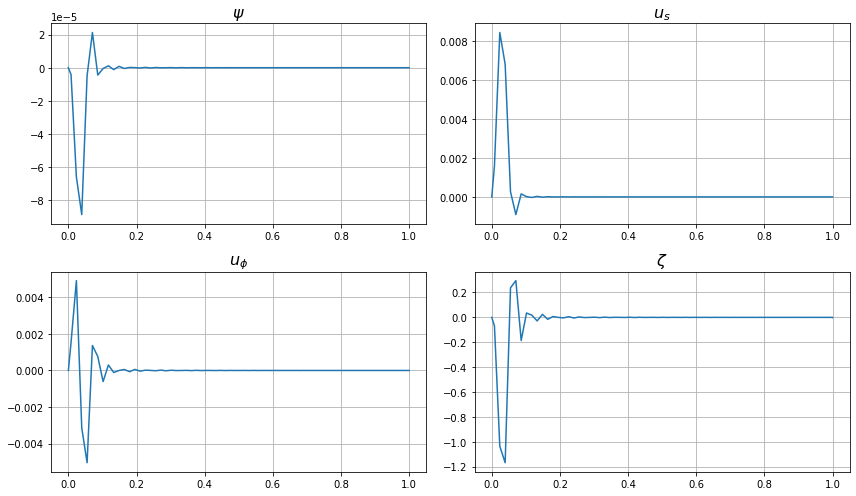

In [48]:
# plot_fields = [["Psi", "U_s", "U_p"],
#                ["Mss", "Mpp", "Msp"], 
#                ["Msz", "Mpz", None], 
#                ["zMss", "zMpp", "zMsp"], 
#                ["Bs_e", "Bp_e", "Bz_e"]]
# plot_fnames = [[None, "$u_s$", r"$u_\phi$"],
#                [None, None, None],
#                [None, None, None],
#                [None, None, None], 
#                [None, None, None],]
plot_fields = [["Psi", "U_s"],
               ["U_p", "Zeta"]]
plot_fnames = [[None, "$u_s$"],
               [r"$u_\phi$", r"$\zeta$"]]

# save_name = "./out/eigen/Malkus/Transformed/mode_radial_m3n5"
save_name = None
override = False

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*3.5))

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        ax.plot(s_array, np.real(eigmode_eval[fname]))
        if np.abs(np.real(eigmode_eval[fname])).max() < 1e-5:
            ax.set_ylim([-1e-5, +1e-5])
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar_ptb[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.grid(True)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Equatorial section

For Equatorial plane section, $z=0$. $s$ and $p$ form a mesh of grid points.

In [49]:
z_cst = 0
# s_array = np.linspace(0, 1, num=100)
xi_array, _ = specfun.roots_chebyt(100)
s_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]
p_array = np.linspace(0, 2*np.pi, num=400)
S_mesh, P_mesh = np.meshgrid(s_array, p_array)
X_mesh, Y_mesh = S_mesh*np.cos(P_mesh), S_mesh*np.sin(P_mesh)

Calculate all fields

In [50]:
def calc_field_equatorial(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, N_tmp = np.meshgrid(s_array, np.arange(field_nrange[fname]), indexing='ij')
    eval_tmp = field_f(S_tmp, 0., z_cst, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    eval_rad = np.sum(eval_tmp, axis=-1)
    eval_azm = np.exp(1j*physical_params[xpd.m]*p_array)
    return np.outer(eval_azm, eval_rad)
    # S_tmp, P_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([P_mesh,]*N_trial, axis=-1)
    # N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    # eval_tmp = field_f(S_tmp, P_tmp, z_cst, N_tmp, *[vec for vec in eigvec])
    # if np.array(eval_tmp).ndim == 0:
    #     return eval_tmp*np.ones_like(S_mesh[...,0])
    # eval_tmp[np.isnan(eval_tmp)] = 0.
    # return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_equatorial, inplace=False, metadata=True)

Plot all fields

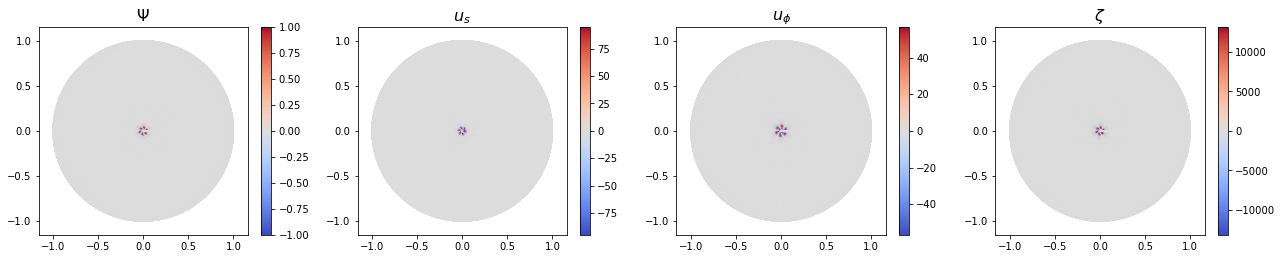

In [51]:
# plot_fields = [["Psi", "U_s", "U_p", "U_z"],
#                ["Mss", "Mpp", "Msp", "zMsp"], 
#                ["Msz", "Mpz", "zMss", "zMpp"], 
#                ["Bs_e", "Bp_e", "Bz_e", "Zeta"]]
# plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$u_z$"],
#                [None, None, None, None], 
#                [None, None, None, None], 
#                [None, None, None, r"$\zeta$"]]
plot_fields = [["Psi", "U_s", "U_p", "Zeta"],]
plot_fnames = [[None, r"$u_s$", r"$u_\phi$", r"$\zeta$"],]

# save_name = "./out/eigen/Malkus/Transformed/mode_equatorial_m3n5"
save_name = None
override = False

# max_norm = max([np.abs(np.real(eigmode_eval[plot_fields[i_r][i_c]])).max() 
#                 for i_r in range(nrows) for i_c in range(ncols) 
#                 if plot_fields[i_r][i_c] is not None and plot_fields[i_r][i_c] != "Zeta"])
max_norm = np.abs(np.real(eigmode_eval["Psi"])).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.5, nrows*3.7))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm")
            plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X_mesh, Y_mesh, np.real(eigmode_eval[fname])/max_norm, shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

### Meridional section

For meridional plane section, $\phi=Cst$. $s$ and $z$ form a mesh of grid points.

In [52]:
p_cst = np.pi/4
xi_array, _ = specfun.roots_chebyt(80)
r_array = np.r_[0, np.sqrt((1 + xi_array)/2), 1]
theta_array = np.linspace(0, np.pi, num=200)
R_mesh, T_mesh = np.meshgrid(r_array, theta_array)
S_mesh, Z_mesh = R_mesh*np.sin(T_mesh), R_mesh*np.cos(T_mesh)

Calculate only the velocity and vorticity fields;

In [53]:
def calc_field_meridional(fname, field_f):
    if fname not in ("U_s", "U_p", "U_z", "Zeta"):
        return None
    N_trial = field_nrange[fname]
    S_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, p_cst, Z_tmp, N_tmp, *[vec for vec in eigvec])
    if np.array(eval_tmp).ndim == 0:
        return eval_tmp*np.ones_like(S_mesh[...,0])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

eigmode_eval = field_func.apply(calc_field_meridional, inplace=False, metadata=True)

Plot fields.

Note: physically, only plotting the fields defined in 3-D space make sense. Therefore, none of the PG variables have meridional plot, as all of the fields are defined in 2-D (most in the unit disk, $B_r$ on the surface of the sphere).

The only field with full volumetric definition is the velocity field, which of course takes the form of the ansatz.

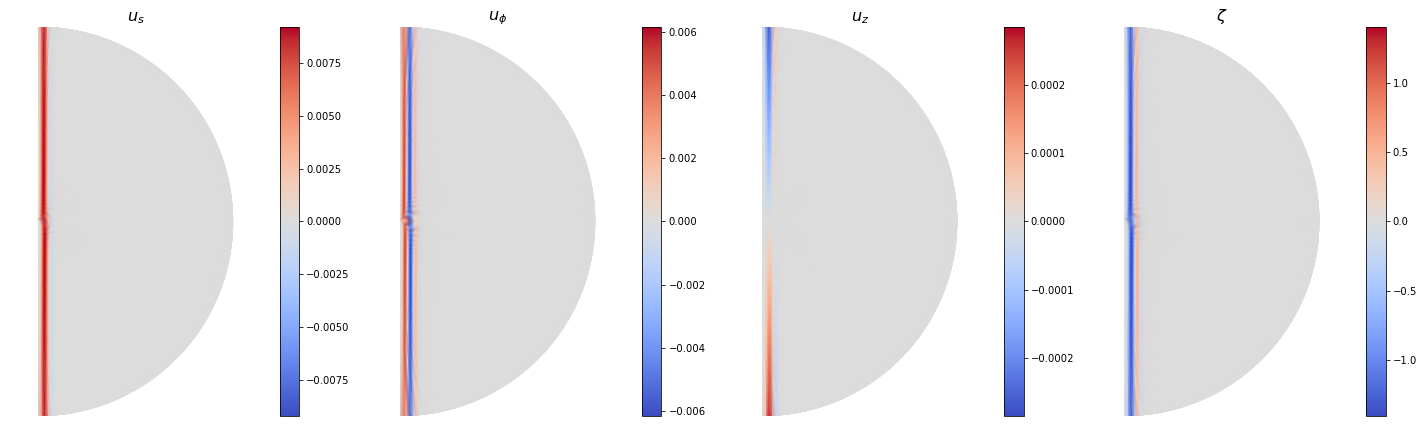

In [54]:
plot_fields = [["U_s", "U_p", "U_z", "Zeta"],]
plot_fnames = [[r"$u_s$", r"$u_\phi$", r"$u_z$", r"$\zeta$"],]
save_name = None
# save_name = "./out/eigen/Malkus/Transformed/mode_meridional_m3n5"
override = False

force_symmetric_cmap = True

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*6))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        if np.abs(np.real(eigmode_eval[fname])).max() > 1e-5:
            if force_symmetric_cmap:
                climit = np.max(np.abs(np.real(eigmode_eval[fname])))
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(S_mesh, Z_mesh, np.real(eigmode_eval[fname]), shading="gouraud", cmap="coolwarm", vmin=-1e-5, vmax=+1e-5)
            plt.colorbar(cm, ax=ax)
        if fname in core.pgvar._field_names:
            ax.set_title(r'$%s$' % (core.pgvar[fname].name,), fontsize=16)
        else:
            ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.axis("equal")
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()

---
## Eigenmode spectrum

Read in eigenvalue solutions

In [86]:
from pg_utils.numerics import matrices as nmatrix
from pg_utils.pg_model import expansion as xpd
from pg_utils.pg_model import params

eigen_files_list = [
    # "./out/eigen/Malkus/Transformed/eigen_m3_N5.h5", 
    # "./out/eigen/Malkus/Transformed/eigen_m3_N50.h5",
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N5.h5", 
    # "./out/eigen/Hydrodynamic/Reduced/eigen_m3_N50.h5", 
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N20.h5",
    # "./out/eigen/Toroidal_Quadrupole/Transformed/eigen_m3_N50.h5",
    "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N20.h5",
    "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N50.h5",
    "./out/eigen/Toroidal_Quadrupole/Reduced/eigen_m3_Le-2_N80.h5",
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N20.h5",
    # "./out/eigen/Poloidal_Dipole/Transformed/eigen_m3_N50.h5",
]
label_list = [
    # For instance, the truncation level can be used as labels
    # 5,
    # 10,
    20,
    50,
    80,
    # 100
]

eig_val_list = list()
eig_vec_list = list()
cnames_list = list()
ranges_list = list()
params_list = list()
for idx, fname in enumerate(eigen_files_list):
    with h5py.File(fname, 'r') as f:
        eig_vals = f["eigval"][()]
        eig_vecs = f["eigvec"][()]
        cnames = list(f["bases"]["names"].asstr()[()])
        ranges = f["bases"]["ranges"][()]
        if "azm" in f.attrs.keys():
            params_list.append({
                xpd.m: f.attrs["azm"], 
                params.Le :f.attrs["Le"]})
        else:
            params_list.append({parse_expr(key): f.attrs[key] for key in f.attrs.keys()})
    eig_val_list.append(eig_vals)
    eig_vec_list.append(eig_vecs)
    cnames_list.append(cnames)
    ranges_list.append(ranges)

### Sorting eigenmodes

East/west splitting. The following code block classifies the eigenvalues into
1. Eastwards modes and their eigenvalues (imaginary part smaller than a negative threshold)
2. Westwards modes and their eigenvalues (imaginary part greater than a positive threshold)

In [87]:
func_collections = [
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=-1e-7, transform_filter=np.imag, transform_sort=np.imag),
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=+1e-7, transform_filter=np.imag, transform_sort=np.imag, reversed=True)
]

Fast/slow splitting. The following code block classifies the eigenvalues into
1. Fast modes and their eigenvalues (absolute value of imaginary part greater than a threshold)
2. Slow modes and their eigenvalues (absolute value of imaginary part less than a threshold)

In [75]:
func_colletions = [
    lambda x: pproc.filter_sort(x, filter_op=np.greater, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), reversed=True),
    lambda x: pproc.filter_sort(x, filter_op=np.less, threshold=1e+1, transform_filter=lambda x: np.abs(np.imag(x)), transform_sort=lambda x: np.abs(np.imag(x)), remove_zero=1e-9)
]

Collect the results according to the classification criterion

In [89]:
ds_vals_collections = [list() for func in func_collections]
ds_vecs_collections = [list() for func in func_collections]

for i_src, label in enumerate(label_list):
    eig_vals_classes = pproc.classify_eigens_criteria(eig_val_list[i_src], func_collections)
    eig_vecs_classes = [eig_vec_list[i_src][:, eig_class[1]] for eig_class in eig_vals_classes]
    eig_vals_classes = [eig_class[0] for eig_class in eig_vals_classes]
    for i_ds, ds_tmp in enumerate(ds_vals_collections):
        ds_vals_collections[i_ds].append(eig_vals_classes[i_ds])
        ds_vecs_collections[i_ds].append(nmatrix.LabeledBlockArray(eig_vecs_classes[i_ds], cnames_list[i_src], ranges_list[i_src]))

### Eigenvalue spectrum

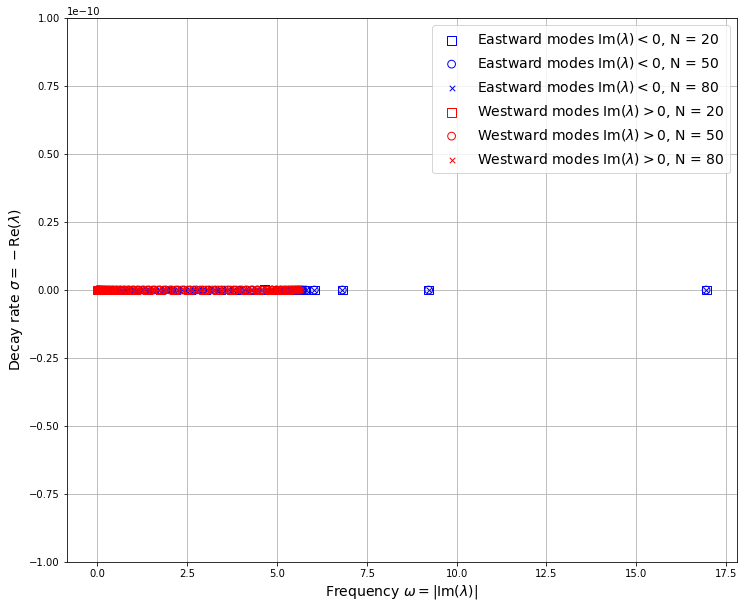

In [119]:
fig, ax = plt.subplots(figsize=(12, 10))

style_cfg = [
    [
        {'s': 80, "marker": 's', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'b', "linewidths": 1},
    ],
    [
        {'s': 80, "marker": 's', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'r', "linewidths": 1},
    ],
]
ds_name = [
    r"Eastward modes $\mathrm{Im}(\lambda) < 0$",
    r"Westward modes $\mathrm{Im}(\lambda) > 0$"
]

for i_ds in range(len(ds_vals_collections)):
    for i_src in range(len(label_list)):
        if style_cfg[i_ds][i_src] is None:
            continue
        ax.scatter(np.abs(np.imag(ds_vals_collections[i_ds][i_src])), -np.real(ds_vals_collections[i_ds][i_src]),
            **style_cfg[i_ds][i_src], label="%s, N = %d" % (ds_name[i_ds], label_list[i_src]), zorder=5)

ax.set_xlabel(r"Frequency $\omega = |\mathrm{Im}(\lambda)|$", fontsize=14)
ax.set_ylabel(r"Decay rate $\sigma = -\mathrm{Re}(\lambda)$", fontsize=14)

# ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=1e-7, linscale=.1)
# ax.set_xlim([4, 6])
ax.set_ylim([-1e-10, +1e-10])

ax.grid(which="both")
ax.legend(fontsize=14)

plt.show()

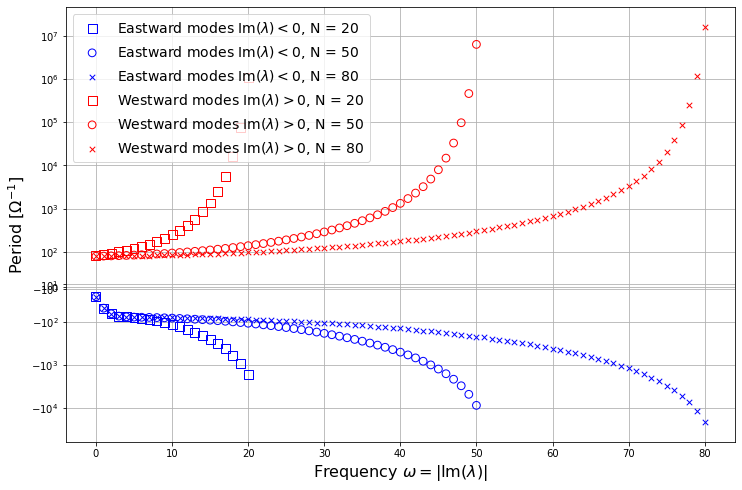

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))

style_cfg = [
    [
        {'s': 80, "marker": 's', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'b', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'b', "linewidths": 1},
    ],
    [
        {'s': 80, "marker": 's', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 60, "marker": 'o', "edgecolors": 'r', "facecolors": "none", "linewidths": 1},
        {'s': 30, "marker": 'x', "color": 'r', "linewidths": 1},
    ],
]
ds_name = [
    r"Eastward modes $\mathrm{Im}(\lambda) < 0$",
    r"Westward modes $\mathrm{Im}(\lambda) > 0$"
]

for i_ds in range(len(ds_vals_collections)):
    for i_src in range(len(label_list)):
        if style_cfg[i_ds][i_src] is None:
            continue
        ax.scatter(
            np.arange(ds_vals_collections[i_ds][i_src].size),
            np.sign(np.imag(ds_vals_collections[i_ds][i_src]))*2*np.pi/(params_list[i_src][params.Le]*np.abs(np.imag(ds_vals_collections[i_ds][i_src]))),
            **style_cfg[i_ds][i_src], label="%s, N = %d" % (ds_name[i_ds], label_list[i_src]), zorder=5)

ax.set_xlabel(r"Frequency $\omega = |\mathrm{Im}(\lambda)|$", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)

ax.set_yscale('symlog', linthresh=20, linscale=0.1)
# ax.set_xlim([-1, 20])
# ax.set_ylim([1e+1, 1e+3])

ax.grid(which="both")
ax.legend(fontsize=14)

plt.show()

Inspect eigenvalues

In [135]:
class_idx = 1
trunc_N = min([ds_vals_collections[class_idx][i_src].size for i_src in range(len(label_list))])

df = pd.DataFrame(data={label_list[i_src]: ds_vals_collections[class_idx][i_src][:trunc_N] for i_src in range(len(label_list))})
df.style.format(formatter=lambda x: "{0.real:.2e},{0.imag:.7e}j".format(x))

,20,50,80
0,"1.78e-15,5.3215154e+00j","-8.88e-16,5.6201690e+00j","1.78e-15,5.6625682e+00j"
1,"-3.60e-15,5.0872443e+00j","1.80e-15,5.5736359e+00j","6.44e-16,5.6434049e+00j"
2,"-2.67e-15,4.7902024e+00j","6.22e-15,5.5133276e+00j","-9.85e-16,5.6184985e+00j"
3,"4.46e-15,4.4730876e+00j","-1.57e-15,5.4469117e+00j","3.84e-15,5.5909603e+00j"
4,"-4.31e-16,4.1164857e+00j","-1.84e-15,5.3695546e+00j","-1.63e-15,5.5587465e+00j"
5,"3.39e-15,3.7430159e+00j","5.26e-15,5.2848375e+00j","3.29e-15,5.5232761e+00j"
6,"-3.54e-15,3.3478140e+00j","1.43e-15,5.1905264e+00j","-1.43e-14,5.4835565e+00j"
7,"4.65e-16,2.9470133e+00j","-3.50e-15,5.0888177e+00j","5.69e-15,5.4404238e+00j"
8,"2.33e-16,2.5419046e+00j","3.67e-15,4.9785444e+00j","-5.06e-15,5.3933088e+00j"
9,"-2.74e-15,2.1455323e+00j","5.03e-16,4.8612797e+00j","-8.98e-15,5.3427783e+00j"


### Eigenvalue plot

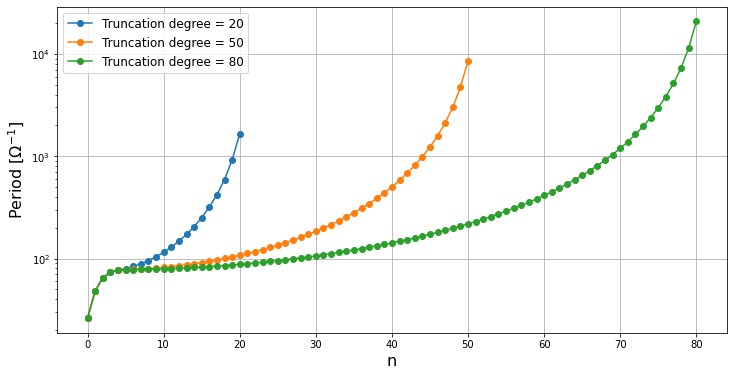

In [103]:
class_idx = 0

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# save_name = "./out/cases/Hydrodynamic/Recipe_Conjugate/m3_leading_10_eigenmodes"
save_name = None

for i_src in range(len(label_list)):
    ax.plot(2*np.pi/(params_list[i_src][params.Le]*np.abs(np.imag(ds_vals_collections[class_idx][i_src]))), 
            'o-',
            label="Truncation degree = {:d}".format(label_list[i_src]))

ax.set_yscale("log")
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"Period [$\Omega^{-1}$]", fontsize=16)
ax.legend(fontsize=12)
ax.grid()

# ax.set_xlim([-1, 20])
# ax.set_ylim([10, 1e+3])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

### Spectrum of the solution

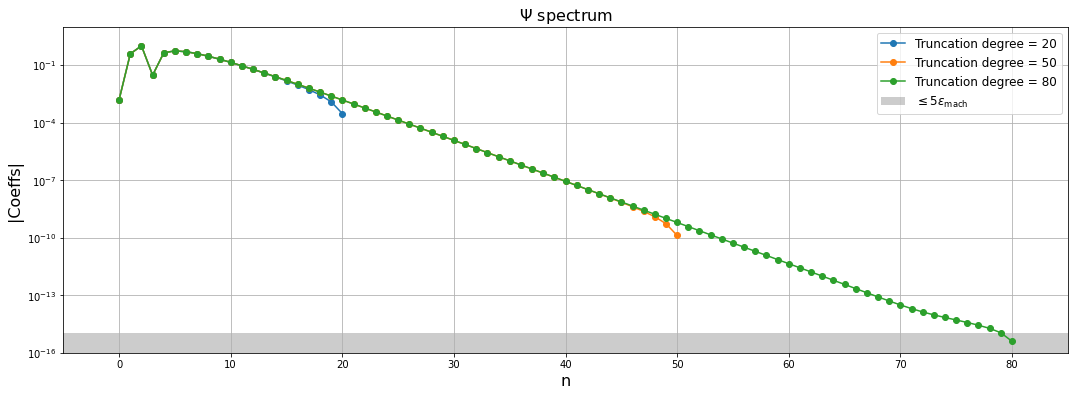

In [129]:
# Choose which field to check
class_idx = 0
mode_idx = 3
field_name = "Psi"
field_title = r"$\Psi$"

# save_name = "./out/eigen/Malkus/Transformed/spectrum_m3n%d" % n
save_name = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

for i_src in range(len(label_list)):
    eig_cfs = ds_vecs_collections[class_idx][i_src][field_name]
    if eig_cfs.shape[1] <= mode_idx:
        continue
    ax.plot(np.abs(eig_cfs[:, mode_idx])/np.max(np.abs(eig_cfs[:, mode_idx])), 
            'o-', label="Truncation degree = {:d}".format(label_list[i_src]))

coeff_min = np.abs(np.abs(eig_cfs[:, mode_idx])).min()/np.max(np.abs(eig_cfs[:, mode_idx]))
ax.fill_between([-5, max(label_list)+5], min([1e-20, coeff_min])*np.ones(2), 5*np.finfo(np.float64).eps*np.ones(2), 
    facecolor="gray", alpha=0.4, label="$\leq 5\epsilon_{\mathrm{mach}}$")

ax.set_title(r"{:s} spectrum".format(field_title), fontsize=16)
ax.set_yscale("log")
ax.set_xlabel("n", fontsize=16)
ax.set_ylabel(r"|Coeffs|", fontsize=16)
ax.legend(fontsize=12)
ax.grid(which="both")

ax.set_xlim([-5, max(label_list)+5])
ax.set_ylim([min([1e-16, coeff_min]), 10])

if save_name is not None:
    plt.savefig(save_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.savefig(save_name + ".png", format="png", bbox_inches="tight", dpi=150)

plt.show()

---

## Miscellaneous

### Peek eigenvalues

### Matrix visualization

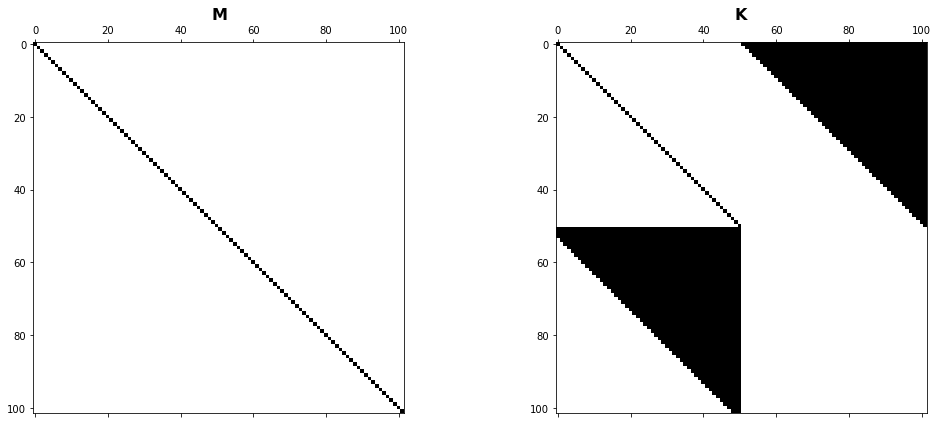

In [126]:
from pg_utils.numerics import io as num_io

# matrix_file = "./out/cases/Malkus/Reduced_sys/Matrix_eval.h5"
# matrix_file = "./out/cases/Hydrodynamic/Recipe_Conjugate/Matrix_eval_N10.h5"
# matrix_file = "./out/eigen/Hydrodynamic/Transformed/matrix_m3_N5.h5"
# matrix_file = "./out/eigen/Toroidal_Quadrupole/Transformed/matrix_m3_N20.h5"
matrix_file = "./out/eigen/Toroidal_Quadrupole/Reduced/matrix_m3_Le-2_N50.h5"

with h5py.File(matrix_file, 'r') as fread:
    M_tmp = num_io.matrix_load_from_group(fread["M"])
    K_tmp = num_io.matrix_load_from_group(fread["K"])
    if not isinstance(M_tmp, np.ndarray):
        M_tmp = M_tmp.todense()
        K_tmp = K_tmp.todense()

visual_prec = 1e-9
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.spy(M_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{M}$", fontsize=16)

ax = axes[1]
ax.spy(K_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{K}$", fontsize=16)

plt.tight_layout()
# plt.savefig("./out/imgs/sparsity__hydrodynamic_cg.png", format="png", bbox_inches="tight")
plt.show()

### Output to 3-D visualization

In [115]:
r_array = np.arange(0.05, 1, 0.1)
theta_array = np.arange(0, 181, 5)
phi_array = np.arange(0, 360, 5)

R_mesh, Phi_mesh, Theta_mesh = np.meshgrid(r_array, np.radians(phi_array), np.radians(theta_array), indexing='ij')
S_mesh = R_mesh*np.sin(Theta_mesh)
Z_mesh = R_mesh*np.cos(Theta_mesh)

def calc_field_3d(fname, field_f):
    N_trial = field_nrange[fname]
    S_tmp, P_tmp, Z_tmp = np.stack([S_mesh,]*N_trial, axis=-1), np.stack([Phi_mesh,]*N_trial, axis=-1), np.stack([Z_mesh,]*N_trial, axis=-1)
    N_tmp = np.stack([N_tmp*np.ones_like(S_mesh) for N_tmp in np.arange(N_trial)], axis=-1)
    eval_tmp = field_f(S_tmp, P_tmp, Z_tmp, N_tmp, *[vec for vec in eigvec])
    eval_tmp[np.isnan(eval_tmp)] = 0.
    return np.sum(eval_tmp, axis=-1)

Zeta_mesh = calc_field_3d("Zeta", field_func.Zeta)
Uz_mesh = calc_field_3d("U_z", field_func.U_z)

In [117]:
np.savez("./out/cases/Malkus/3darray.npz", r_array=r_array, theta_array=theta_array, phi_array=phi_array, Zeta=Zeta_mesh, Uz=Uz_mesh)